In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [6]:
test.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [7]:
df.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [17]:
def drop(x):
    x=x.drop(columns = 'id',axis =1)
    return x

In [24]:
df_clean = drop(df)
test_clean = drop(test)

In [25]:
corr = df_clean.corr(numeric_only=True)

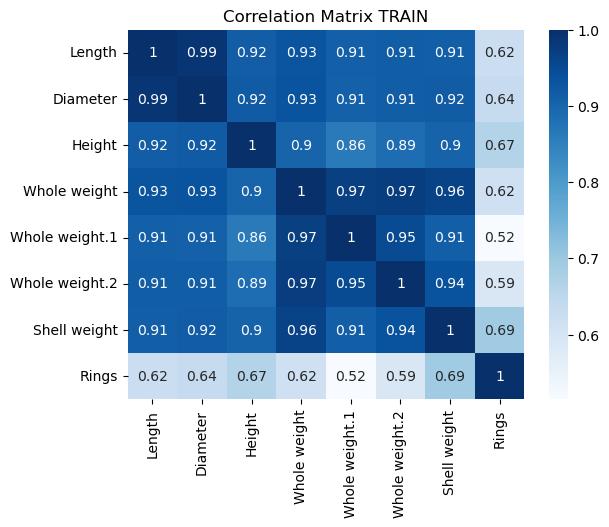

In [27]:
sns.heatmap(corr , annot = True,cmap = 'Blues')
plt.title("Correlation Matrix TRAIN")
plt.show()

In [28]:
corr_t = test_clean.corr(numeric_only=True)

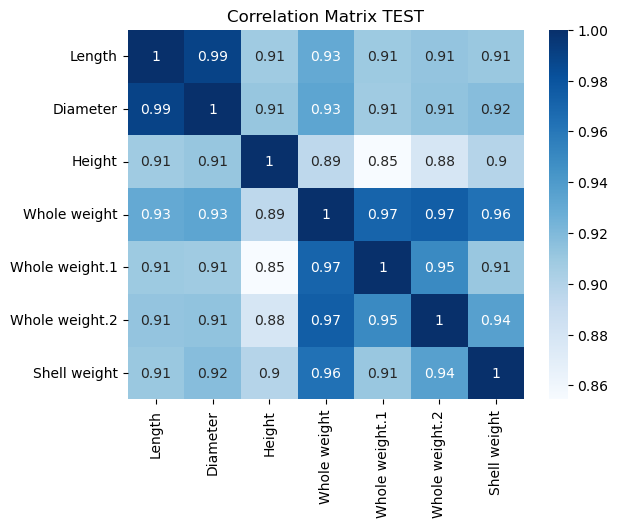

In [29]:
sns.heatmap(corr_t , annot = True,cmap = 'Blues')
plt.title("Correlation Matrix TEST")
plt.show()

 The correlation matrces shows that all the numerical features are storngly correlated.The target variable Rings also strongly correlated with all the numerical features.

In [37]:
def plot_boxplots(df, features):
    num_features = len(features)
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
    for i, feature in enumerate(features):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
       
        sns.boxplot(x=df[feature], ax=ax)
        ax.set_title(f'Boxplot of {feature}', fontsize=14)
    
    plt.tight_layout()
    
    plt.show()


In [38]:
num = df_clean.select_dtypes(exclude='object').columns

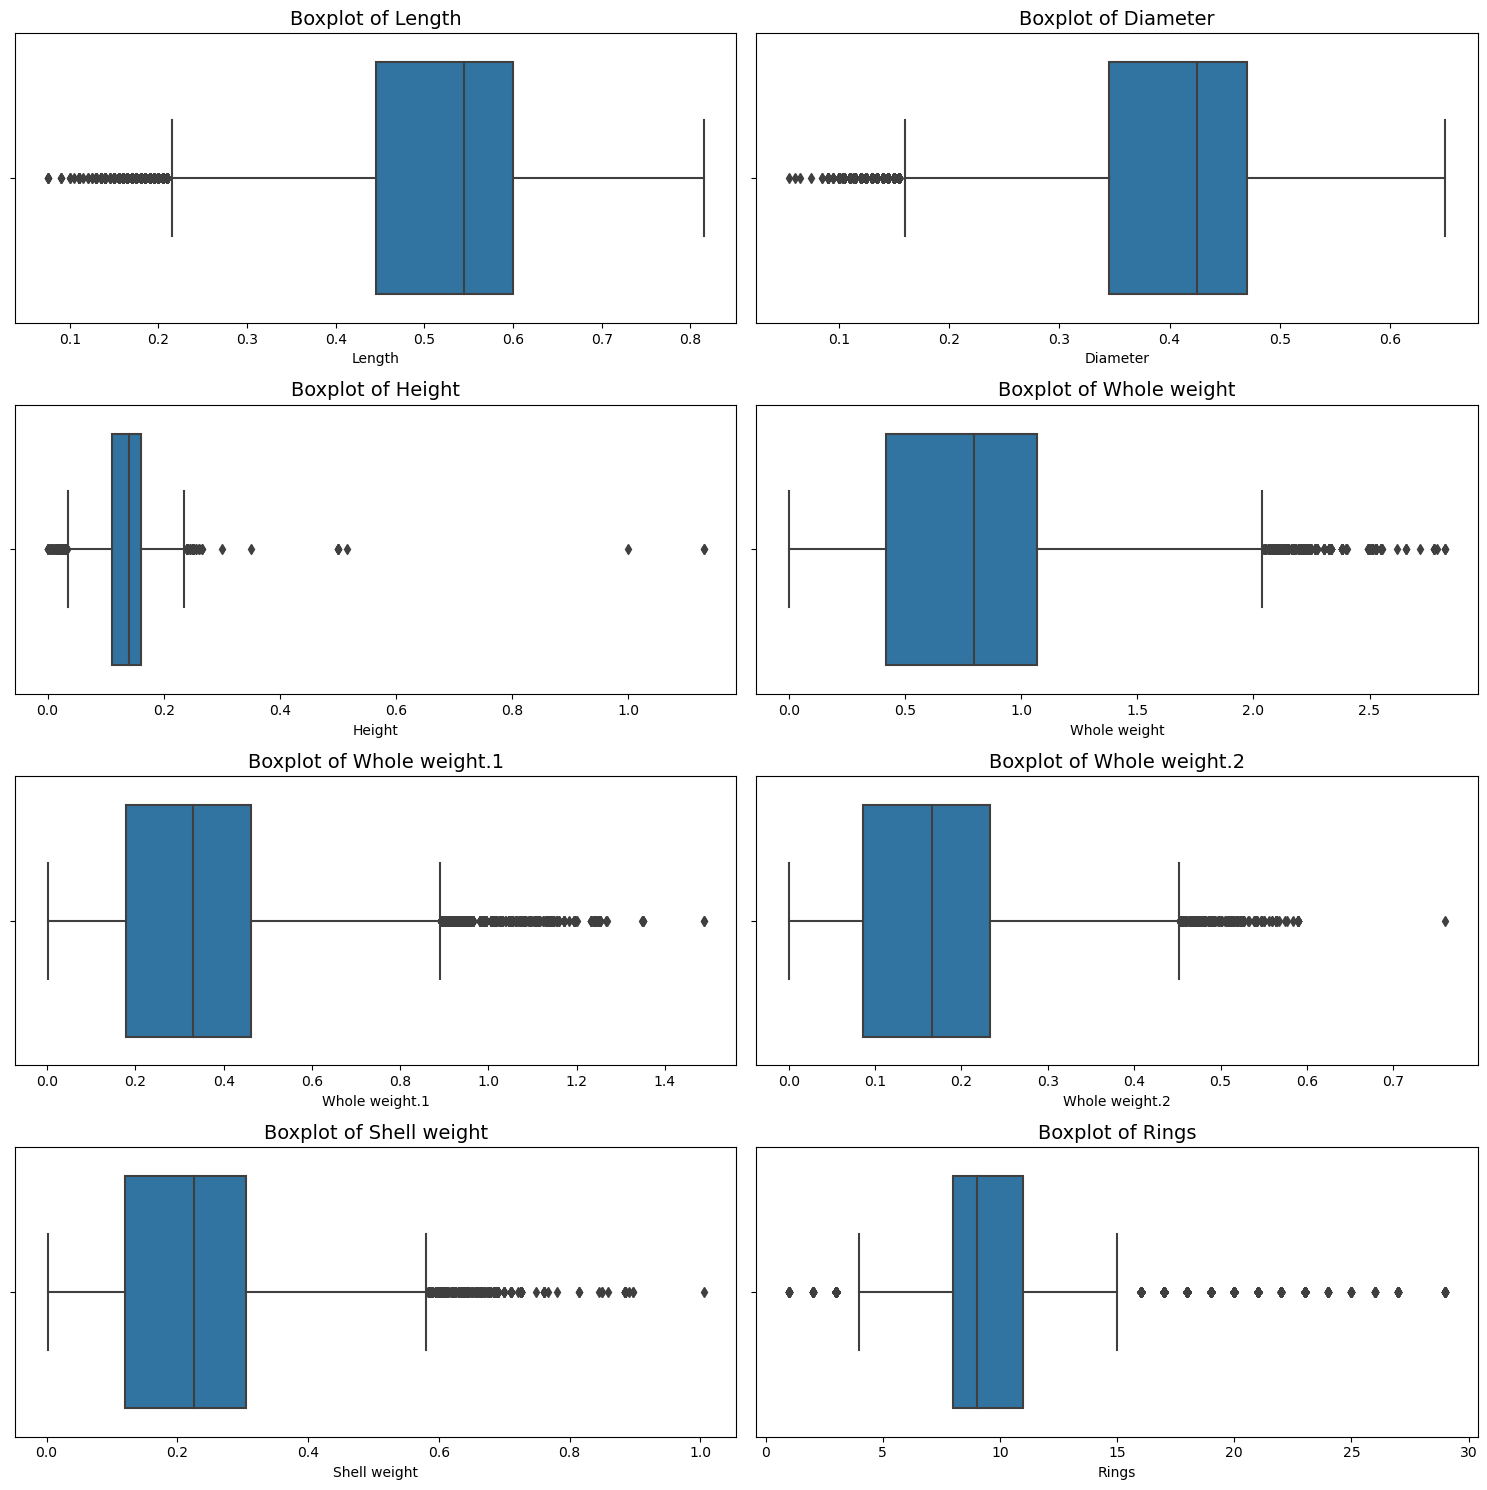

In [39]:
plot_boxplots(df_clean,num)

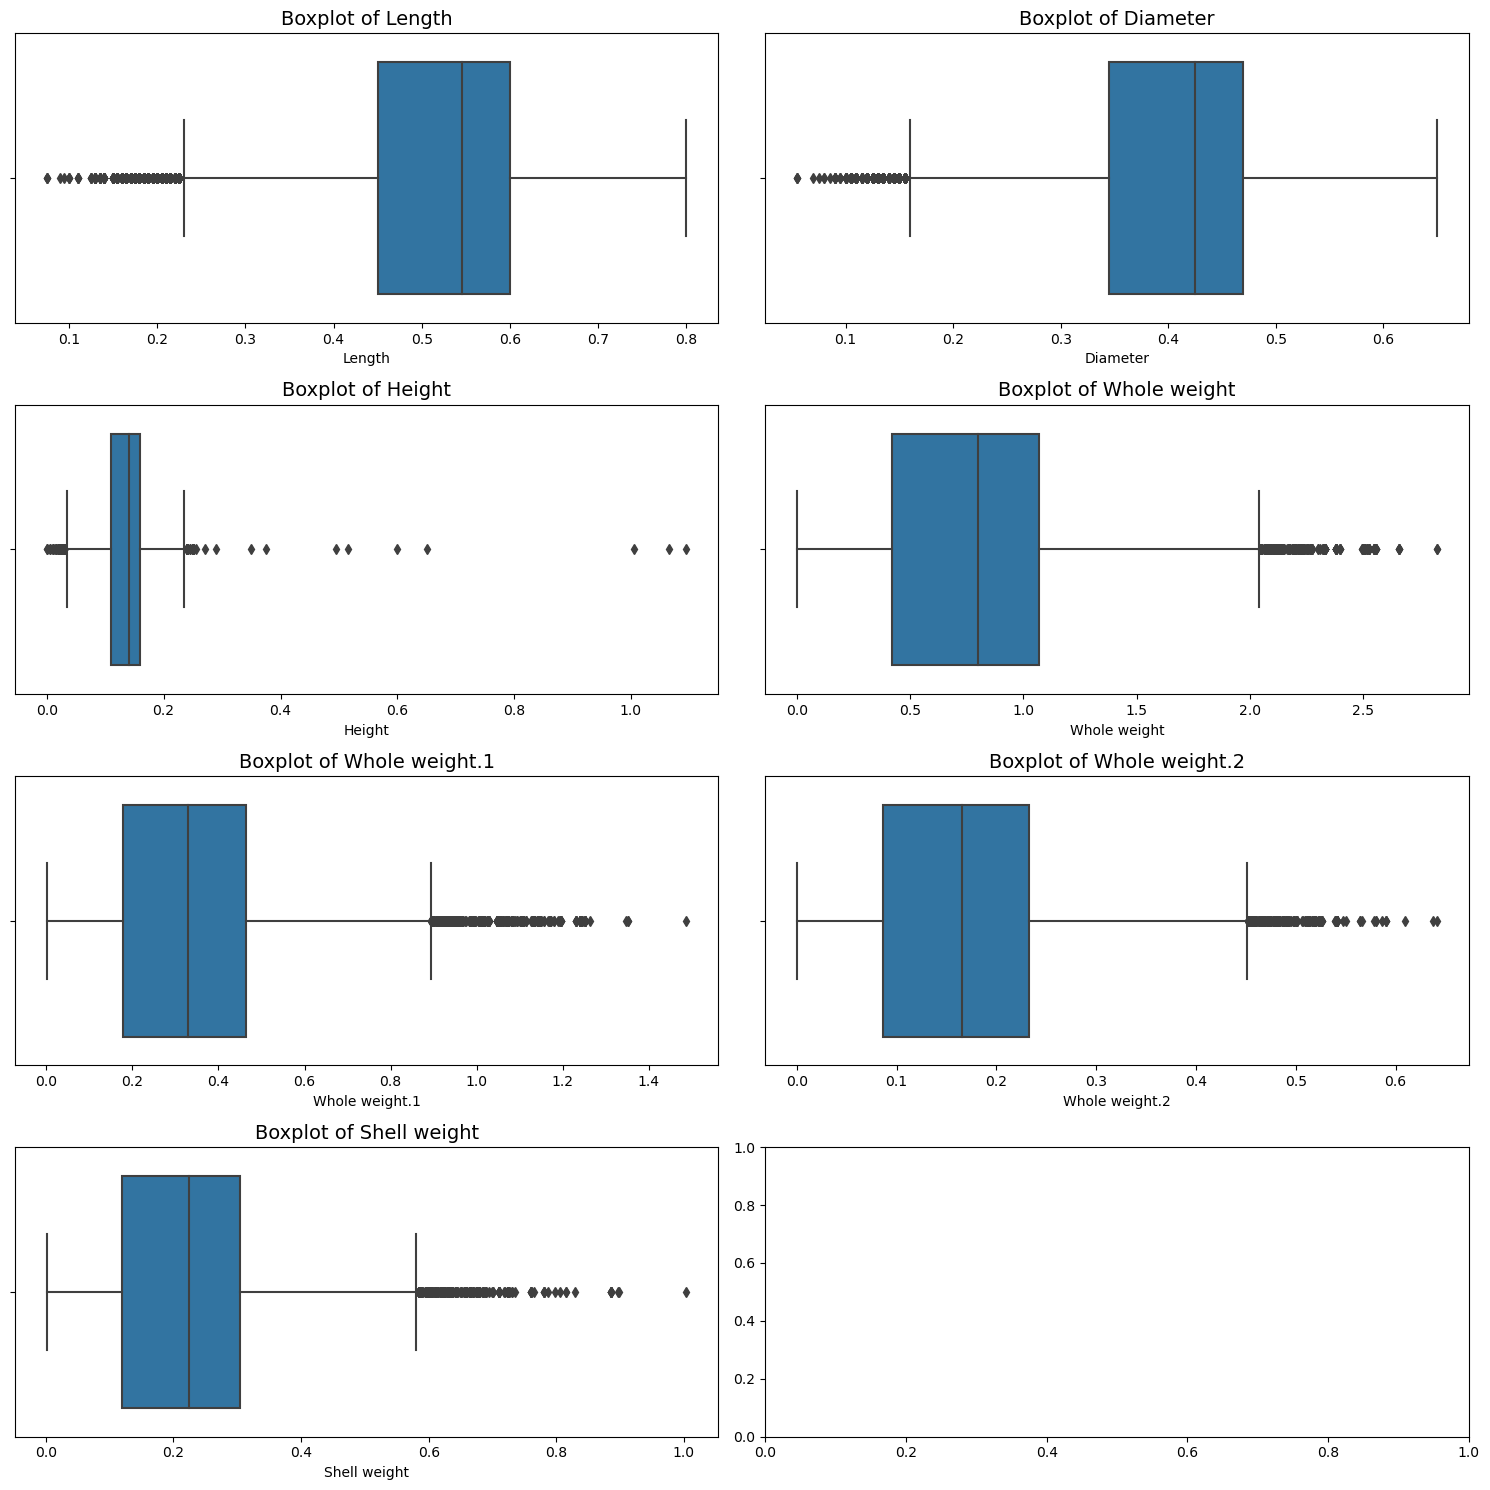

In [40]:
num = test_clean.select_dtypes(exclude='object')
plot_boxplots(test_clean,num)

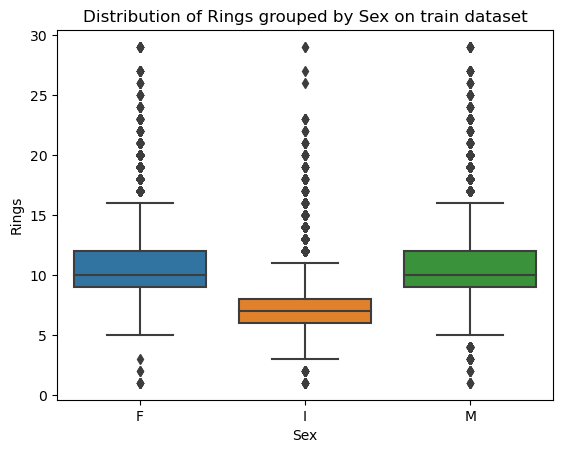

In [41]:
sns.boxplot(x='Sex', y='Rings', data=df_clean)
plt.title('Distribution of Rings grouped by Sex on train dataset')
plt.show()

In [43]:
df_clean['stage'] = np.where(df_clean['Sex']=='I','Infant','Adult')

In [44]:
test_clean['stage'] = np.where(test_clean['Sex']=='I','Infant','Adult')

In [45]:
df_clean.drop(columns=['Sex'],inplace = True)

In [46]:
test_clean.drop(columns=['Sex'],inplace = True)

In [51]:
from sklearn.preprocessing import RobustScaler , MinMaxScaler,LabelEncoder
le = LabelEncoder()
rs = RobustScaler()
mms = MinMaxScaler()

In [68]:
def scale(df):
    df['stage'] = le.fit_transform(df['stage'])
    df = rs.fit_transform(df)
    df = mms.fit_transform(df)
    df = pd.DataFrame(df,columns = rs.get_feature_names_out())
    return df

In [69]:
X = df_clean.drop(columns='Rings')
y = df_clean['Rings']

In [70]:
X= scale(X)
test_scale =scale(test_clean)


In [73]:
y = np.sqrt(y)

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [76]:
from sklearn.ensemble import RandomForestRegressor ,VotingRegressor , BaggingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV , cross_val_score

### RandonForest Hyperparameter Tuning using RandomizedSearchCV

In [121]:
param_dist_rf = {
    'n_estimators': [100,150,200],
    'max_depth': [3,5,6,7],
    'min_samples_split': [6,8,20],
    'min_samples_leaf': [12,14,16],
    'max_features': [1.0, 0.8, 0.6]
}

In [122]:
rf = RandomForestRegressor(random_state=42)

In [123]:
rscv = RandomizedSearchCV(estimator=rf,param_distributions=param_dist_rf,n_iter=10,cv=5,scoring='neg_mean_squared_log_error',
                         random_state=42,verbose=1)

In [124]:
%%time
rscv.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 34.2 s
Wall time: 5min 38s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_depth': [3, 5, 6, 7],
                                        'max_features': [1.0, 0.8, 0.6],
                                        'min_samples_leaf': [12, 14, 16],
                                        'min_samples_split': [6, 8, 20],
                                        'n_estimators': [100, 150, 200]},
                   random_state=42, scoring='neg_mean_squared_log_error',
                   verbose=1)

In [125]:
rscv.best_score_

-0.004152358411120756

In [126]:
rscv.best_params_

{'n_estimators': 200,
 'min_samples_split': 8,
 'min_samples_leaf': 16,
 'max_features': 1.0,
 'max_depth': 7}

In [127]:
rf = rscv.best_estimator_

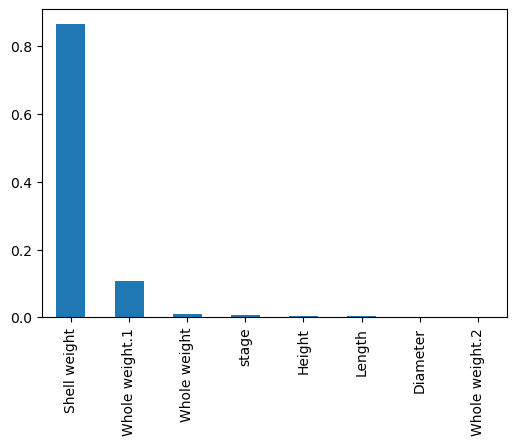

In [128]:
# Get the feature importances
importances = rf.feature_importances_

# Create a DataFrame to display feature importances in decending order
forest_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

# Plot feature importance in descending order
fig, ax = plt.subplots(figsize=(6, 4))
forest_importances.plot.bar(ax=ax);

### XGBoostRegressor Hyperparameter Tuning using RandomizedSearchCV

In [129]:
param_dist_xgb = {
    'n_estimators': [50,100,200],
    'max_depth': [ 3, 5,  7,],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 1.0, 2.0, 3.0, 4.0]
}

In [130]:
xgb = XGBRegressor(random_state=42)

In [131]:
xgb_random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist_xgb, n_iter=20, cv=5, scoring='neg_mean_squared_log_error', random_state=42, n_jobs=-1, verbose=1)

In [132]:
xgb_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200],
                                        'reg_alpha': [0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0, 1.0, 2.0, 3.0, 4.0],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='neg_mean_squared_log_error',
                   verbose=1)

In [133]:
xgb_random_search.best_score_


-0.003940459697816299

In [134]:
xgb_best_estimator = xgb_random_search.best_estimator_


In [135]:
from xgboost import plot_importance

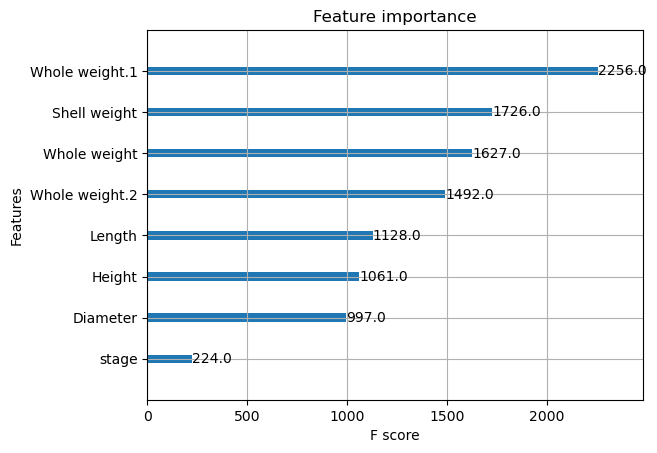

In [136]:
plot_importance(xgb_best_estimator);


In [138]:
param_dist = {
    'n_estimators': [10,40,80,100],  # Number of base estimators in the ensemble
    'max_samples': [0.5, 0.7, 0.9, 1.0],  # Proportion of samples to draw from X to train each base estimator
    'max_features': [0.5, 0.7, 0.9, 1.0],  # Proportion of features to draw from X to train each base estimator
    # Add more hyperparameters as needed
}

In [140]:
bagging_reg = BaggingRegressor()

In [141]:
random_search = RandomizedSearchCV(
    estimator=bagging_reg,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Scoring metric
    random_state=42,
    verbose=1
)

In [142]:
random_search.fit(X_train, y_train)  # Replace X and y with your data


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=BaggingRegressor(),
                   param_distributions={'max_features': [0.5, 0.7, 0.9, 1.0],
                                        'max_samples': [0.5, 0.7, 0.9, 1.0],
                                        'n_estimators': [10, 40, 80, 100]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [143]:
random_search.best_score_

-0.07534100445383163

In [145]:
random_search.best_params_

{'n_estimators': 80, 'max_samples': 0.9, 'max_features': 1.0}

In [144]:
bagging_reg = random_search.best_estimator_

### Creat the VotingRegressor

In [146]:
voting = VotingRegressor([
    ('rf',rf),
    ('XGB',xgb_best_estimator),
    ('bagging',bagging_reg)
])

In [148]:
voting.fit(X_train, y_train)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_depth=7,
                                                   min_samples_leaf=16,
                                                   min_samples_split=8,
                                                   n_estimators=200,
                                                   random_state=42)),
                            ('XGB',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=N...
                                          interaction_constraints=None,
                                          learning_rate=0.05, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=7,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...)),
                            ('bagging',
                             BaggingRegressor(max_samples=0.9,
                                              n_estimators=80))])

In [150]:
preds = voting.predict(test_scale)

In [153]:
sub = pd.DataFrame({
    'id': test.id,
    'Ring':np.square(preds)
})

In [155]:
sub.shape

(60411, 2)

In [156]:
sub.to_csv('submission.csv',index = False)